## Data Preparation
First we import our necessary libraries

In [121]:
#!pip install pygris
#!pip install folium
import pygris
from pygris import tracts
from matplotlib import pyplot as plt
import pandas as pd
import folium
import numpy as np

# Starting up 
As a test of concept, lets utilize the pygris library to access the CT tracts information and then let's do a simple plot to ensure it's correct.

Using FIPS code '09' for input 'CT'


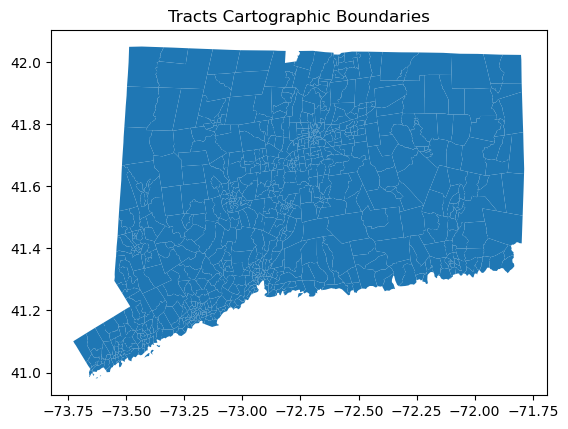

In [14]:
# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

## Graphing Pop-Density
Before we begin our journey into zonal statistics and eventually creating a predictive model, we first want to understand what the population density looks like in Connecticut. We have some general hypotheses that the areas around New Haven and Hartford are going to have higher amounts of population, and we also expect to see some small pockets of communities around Connecticut.

In [15]:
# Import tracts population data
pop = pd.read_csv("../data/population.csv")

# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

### Once we have our tracts, we then calculate pop density and graph 

In [16]:
# Project tracts
tracts = tracts.to_crs("EPSG:2234")

# Calculate area
tracts["Area"] = tracts.area

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]


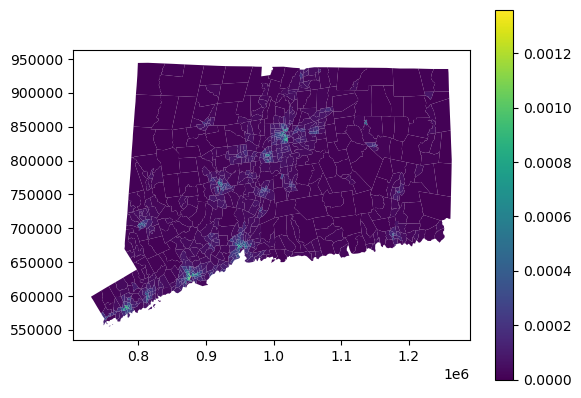

In [17]:
tracts.plot("PopDensity", legend = True);

In [18]:
tracts

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,Geo_PCI,Geo_TAZ,Geo_UGA,Geo_BTTR,Geo_BTBG,Geo_PUMA5,Geo_PUMA1,SE_A00001_001,Area,PopDensity
0,09,001,011000,1400000US09001011000,09001011000,110,CT,4473567,3841130,"POLYGON ((768806.438 564631.131, 773167.739 56...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5496,6.578389e+07,0.000084
1,09,001,020800,1400000US09001020800,09001020800,208,CT,2315472,0,"POLYGON ((779750.763 593331.028, 780102.614 59...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2831,2.494969e+07,0.000113
2,09,001,021400,1400000US09001021400,09001021400,214,CT,1640443,0,"POLYGON ((774314.477 583462.508, 776262.618 58...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6956,1.769721e+07,0.000393
3,09,001,022200,1400000US09001022200,09001022200,222,CT,1442382,117063,"POLYGON ((780699.029 578728.334, 781267.249 57...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4468,1.667225e+07,0.000268
4,09,001,043100,1400000US09001043100,09001043100,431,CT,6652660,58522,"POLYGON ((801316.652 604980.220, 803589.804 60...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4894,7.210574e+07,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,09,007,610300,1400000US09007610300,09007610300,6103,CT,16389995,222770,"POLYGON ((1055056.154 680079.089, 1059941.959 ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4179,1.789226e+08,0.000023
829,09,009,120200,1400000US09009120200,09009120200,1202,CT,6878579,542471,"POLYGON ((897298.354 686860.960, 898586.789 68...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6566,8.004847e+07,0.000082
830,09,005,310300,1400000US09005310300,09005310300,3103,CT,970203,0,"POLYGON ((897220.702 850485.688, 898674.905 85...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1416,1.036246e+07,0.000137
831,09,009,141600,1400000US09009141600,09009141600,1416,CT,1067640,0,"POLYGON ((947690.753 677347.410, 947450.392 67...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4962,1.152112e+07,0.000431


## **maybe here we add some enlightening information about our tracts dataframe, otherwise we can remove the code cell above**

## Intro to Zonal Statistics
We are going to do quite a bit here which is being abstracted away by the [`rasterio`](https://pypi.org/project/rasterio/) package. First and foremost, we are going to load in our landcover data from [CONUS](https://www.ncei.noaa.gov/products/satellite/gridded-goes-conus) which is created from satellite date of the Continental United States.

This data comes in the form of a `.tif` file which is a filetype used for storing geographic satellite data.

The goal of zonal statistics here is relatively straightforward, we are going to do some math that involves the pixels in a given geographic satellite image. Each pixel has an associated number which itself is associated with a key. Each pixel is contained in a "tract" which is a measurement of land by the US Census. We perform mathematics like finding the mean type of pixel in a given area, the max, the minimum, etc. This arithmetic is handled by the [`rasterstats`](https://pythonhosted.org/rasterstats/) package.

In [19]:
!pip install rasterio
import rasterio

### First steps 
Here we open our path to our file, and more importantly, we set up our data to be used in zonal statistics. `.read` turns our data into a Numpy Array. Following this we are going to `.transform` our data, which means we are going to take the pixel locations of our coordinates (row col) and map them to our spatial coordinates (x, y). These coordinate values are relative to the [CRS](https://www.ncei.noaa.gov/products/satellite/gridded-goes-conus) (Coordinate Reference System) which we defined earlier as **"EPSG:2234"**

In [20]:
#the data can be accessed from https://coastalimagery.blob.core.windows.net/ccap-landcover/CCAP_bulk_download/High_Resolution_Land_Cover/Phase_2_Expanded_Categories/Legacy_Land_Cover_pre_2024/CONUS/ct_2016_ccap_hires_landcover_20200915.zip
raster_path = '../data/ct_2016_ccap_hires_landcover_20200915.tif'
landcover = rasterio.open(raster_path)
arr = landcover.read(1)
affine = landcover.transform

### Performing Zonal statistics
It's as simple as importing rasterstats. We have handled the important data manipulation, and now it's basically plug and play! One function to note is `.to_crs` which takes in given coordinate reference system and transforms all the points in our dataframe to match that system.

In [ ]:
#!pip install rasterstats

from rasterstats import zonal_stats

# Here is where we ensure our tracts CRS is the same as our landcover CRS
zone = tracts.to_crs(landcover.crs)
stats = zonal_stats(zone, arr, affine=affine)

## BOOM 
We did it! Taking a look at our dataframe we can see what this basic zonal statistics calculated the min, max, mean, and amount of pixels in the tract

In [26]:
df = pd.DataFrame(stats)
df

,min,max,mean,count
0,2.0,21.0,10.746680,6111530
1,2.0,20.0,6.367183,2317904
2,2.0,20.0,3.986602,1644135
3,2.0,21.0,5.371539,1548918
4,2.0,22.0,7.237290,6698858
...,...,...,...,...
828,2.0,22.0,10.200328,16622550
829,2.0,22.0,8.788187,7436780
830,2.0,21.0,4.817850,962686
831,2.0,20.0,3.959455,1070358


## Advanced Zonal Statistics
The `rasterstats` library is very good at getting information from rasters, and we can in fact gain more information by using `categorical = True`. This allows to see the amount of each type of pixel at a given tract.

In [27]:
df_new = zonal_stats(zone, arr, affine=affine, categorical = True)

Taking a look at our dataframe, we can confirm that each column is a type of pixel and each row is a tract

In [35]:
df_categorical = pd.DataFrame(df_new)
df_categorical

,2,5,8,11,12,13,14,15,17,18,19,20,21,22,7,6,0,23
0,1577751.0,1144459.0,23775.0,1180392.0,71818.0,12375.0,1586.0,17531.0,132.0,136572.0,423692.0,142589.0,1378858.0,NaN,NaN,NaN,NaN,NaN
1,809638.0,618991.0,1726.0,846657.0,9915.0,3038.0,NaN,NaN,NaN,NaN,NaN,27939.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1127059.0,252242.0,4375.0,231148.0,15583.0,NaN,NaN,NaN,NaN,NaN,NaN,13728.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1034456.0,216203.0,557.0,91714.0,5287.0,NaN,NaN,NaN,NaN,NaN,20584.0,80161.0,99956.0,NaN,NaN,NaN,NaN,NaN
4,1891481.0,1518050.0,69397.0,2951298.0,59342.0,111854.0,3868.0,14487.0,NaN,NaN,NaN,9940.0,68655.0,486.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,1374277.0,1383902.0,98495.0,11922975.0,160184.0,1003114.0,56206.0,86055.0,NaN,NaN,6618.0,74707.0,296965.0,129120.0,29932.0,NaN,NaN,NaN
829,1822336.0,1031744.0,214670.0,3334055.0,116629.0,19559.0,4997.0,32995.0,NaN,NaN,14223.0,104771.0,594172.0,5431.0,131818.0,9380.0,NaN,NaN
830,533143.0,241203.0,8139.0,141081.0,6149.0,NaN,NaN,1677.0,NaN,NaN,NaN,7344.0,23950.0,NaN,NaN,NaN,NaN,NaN
831,719097.0,191291.0,NaN,148415.0,2535.0,NaN,NaN,NaN,NaN,NaN,NaN,9020.0,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizing Zonal Stats
Now that we have information on the amount of each pixel at a given tract, we can find the most common pixel per tract by using the function `.idxmax()` which will through each row and find the column with the largest value.

In [47]:
df_categorical['max_type'] = df_categorical.idxmax(axis=1)
combined_df = pd.concat([tracts, df_categorical], axis=1)
combined_df['max_type'] = combined_df['max_type'].astype(str)

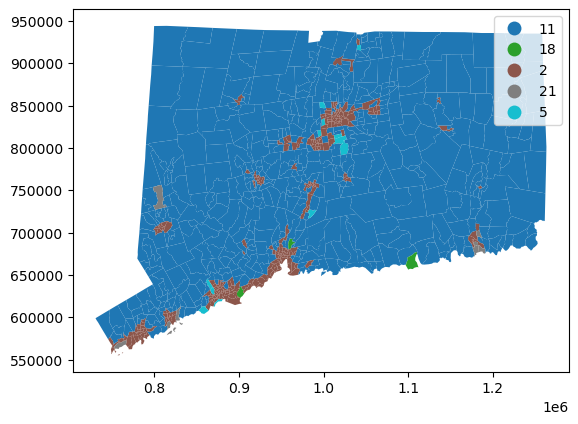

In [48]:
combined_df.plot("max_type", legend = True);

### Saving this data
These statistics took quite a while to run, and it may be beneficial to save this data as a csv to continue running statistics in the future

In [42]:
combined_df.to_csv('combined_data.csv', index=False)

## Fitting a Regression Model

First, we import our data.

In [93]:
# Import and display data
data = pd.read_csv("combined_data.csv")
data.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,18,19,20,21,22,7,6,0,23,max_type
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,"POLYGON ((768806.438288436 564631.1307186291, ...",...,136572.0,423692.0,142589.0,1378858.0,NaN,NaN,NaN,NaN,NaN,2
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,"POLYGON ((779750.7629708104 593331.0275135248,...",...,NaN,NaN,27939.0,NaN,NaN,NaN,NaN,NaN,NaN,11
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,"POLYGON ((774314.4774130288 583462.5078830764,...",...,NaN,NaN,13728.0,NaN,NaN,NaN,NaN,NaN,NaN,2
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,"POLYGON ((780699.029105046 578728.3344804997, ...",...,NaN,20584.0,80161.0,99956.0,NaN,NaN,NaN,NaN,NaN,2
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,"POLYGON ((801316.652144019 604980.2196045901, ...",...,NaN,NaN,9940.0,68655.0,486.0,NaN,NaN,NaN,NaN,11


Looks like there is some missing data in tracts that contain no pixels of a certain class.
Let's impute 0 for all `NaN` values.

In [94]:
# Impute 0 for missing data
print("Before imputation, there were", pd.isnull(data.iloc[:,68:-1]).sum().sum(), "NaN values.")
data[pd.isnull(data.iloc[:,68:-1])] = 0
print("After imputation, there are", pd.isnull(data.iloc[:,68:-1]).sum().sum(), "NaN values.")
data.head()

Before imputation, there were 5774 NaN values.
After imputation, there are 0 NaN values.


,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,18,19,20,21,22,7,6,0,23,max_type
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,"POLYGON ((768806.438288436 564631.1307186291, ...",...,136572.0,423692.0,142589.0,1378858.0,0.0,0.0,0.0,0.0,0.0,2
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,"POLYGON ((779750.7629708104 593331.0275135248,...",...,0.0,0.0,27939.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,"POLYGON ((774314.4774130288 583462.5078830764,...",...,0.0,0.0,13728.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,"POLYGON ((780699.029105046 578728.3344804997, ...",...,0.0,20584.0,80161.0,99956.0,0.0,0.0,0.0,0.0,0.0,2
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,"POLYGON ((801316.652144019 604980.2196045901, ...",...,0.0,0.0,9940.0,68655.0,486.0,0.0,0.0,0.0,0.0,11


Now that we have complete data, we can calculate the proportion of pixels belonging to each class.

In [92]:
# Calculate total number of pixels in each tract
data["sum"] = data.iloc[:,68:-1].sum(axis = 1)

# Calculate proportion of pixels belonging to each class
data.iloc[:,68:-2] = data.iloc[:,68:-2].div(data['sum'], axis=0)

# View data
data.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,19,20,21,22,7,6,0,23,max_type,sum
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,"POLYGON ((768806.438288436 564631.1307186291, ...",...,0.023109,0.007777,0.075205,0.000000,0.0,0.0,0.0,0.0,2,3.0
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,"POLYGON ((779750.7629708104 593331.0275135248,...",...,0.000000,0.001004,0.000000,0.000000,0.0,0.0,0.0,0.0,11,12.0
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,"POLYGON ((774314.4774130288 583462.5078830764,...",...,0.000000,0.002783,0.000000,0.000000,0.0,0.0,0.0,0.0,2,3.0
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,"POLYGON ((780699.029105046 578728.3344804997, ...",...,0.004430,0.017251,0.021511,0.000000,0.0,0.0,0.0,0.0,2,3.0
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,"POLYGON ((801316.652144019 604980.2196045901, ...",...,0.000000,0.000124,0.000854,0.000006,0.0,0.0,0.0,0.0,11,12.0


In [109]:
# Separate predictors and outcome
X = data.iloc[:,68:-2]
y = data["PopDensity"]

In [110]:
# Fit model
# Doing this just for the purpose of seeing what it looks like
# We can use the results from this package to verify that our implementation is working properly
from sklearn.linear_model import LinearRegression
LR = LinearRegression()

m = LR.fit(X, y)

In [114]:
# R^2 value
m.score(X, y)

0.36780743688889106

In [116]:
# Y-intercept
m.intercept_

0.0002797584508240163

In [111]:
# Variable coefficients
m.coef_

array([-4.70924587e-11, -5.33410002e-11,  1.81453411e-11,  3.20802198e-13,
        5.28561824e-11,  5.15375941e-12,  3.07286595e-11, -2.08623041e-11,
       -2.01530231e-09,  3.24754478e-11, -1.37736828e-10, -6.45928639e-11,
       -1.08119794e-11, -9.45070437e-11,  1.70189490e-11,  8.31116515e-12,
       -7.49519438e-11])

In [117]:
# Create predictions (probably should do this on a test set)
preds = LR.predict(X)

In [119]:
data["PopDensity"]

0      0.000084
1      0.000113
2      0.000393
3      0.000268
4      0.000068
         ...   
828    0.000023
829    0.000082
830    0.000137
831    0.000431
832    0.000014
Name: PopDensity, Length: 833, dtype: float64

In [124]:
data

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,18,19,20,21,22,7,6,0,23,max_type
0,9,1,11000,1400000US09001011000,9001011000,110.0,CT,4473567,3841130,"POLYGON ((768806.438288436 564631.1307186291, ...",...,136572.0,423692.0,142589.0,1378858.0,0.0,0.0,0.0,0.0,0.0,2
1,9,1,20800,1400000US09001020800,9001020800,208.0,CT,2315472,0,"POLYGON ((779750.7629708104 593331.0275135248,...",...,0.0,0.0,27939.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,9,1,21400,1400000US09001021400,9001021400,214.0,CT,1640443,0,"POLYGON ((774314.4774130288 583462.5078830764,...",...,0.0,0.0,13728.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,9,1,22200,1400000US09001022200,9001022200,222.0,CT,1442382,117063,"POLYGON ((780699.029105046 578728.3344804997, ...",...,0.0,20584.0,80161.0,99956.0,0.0,0.0,0.0,0.0,0.0,2
4,9,1,43100,1400000US09001043100,9001043100,431.0,CT,6652660,58522,"POLYGON ((801316.652144019 604980.2196045901, ...",...,0.0,0.0,9940.0,68655.0,486.0,0.0,0.0,0.0,0.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
828,9,7,610300,1400000US09007610300,9007610300,6103.0,CT,16389995,222770,POLYGON ((1055056.1536050804 680079.0893559864...,...,0.0,6618.0,74707.0,296965.0,129120.0,29932.0,0.0,0.0,0.0,11
829,9,9,120200,1400000US09009120200,9009120200,1202.0,CT,6878579,542471,"POLYGON ((897298.3538983089 686860.9601360193,...",...,0.0,14223.0,104771.0,594172.0,5431.0,131818.0,9380.0,0.0,0.0,11
830,9,5,310300,1400000US09005310300,9005310300,3103.0,CT,970203,0,"POLYGON ((897220.7020867359 850485.6876548807,...",...,0.0,0.0,7344.0,23950.0,0.0,0.0,0.0,0.0,0.0,2
831,9,9,141600,1400000US09009141600,9009141600,1416.0,CT,1067640,0,"POLYGON ((947690.7531312875 677347.4104160045,...",...,0.0,0.0,9020.0,0.0,0.0,0.0,0.0,0.0,0.0,2


It would be cool to make a map of the predictions and have it next to a map of the actual values.

# To do
- move `combined_data.csv` to data directory
- determine units of our popdensity
- set up code to automatically install packages if they are not yet installed, otherwise import all packages at top of notebook
- set raster processing cells not to run by default
- perform cross-validation or create training and test data sets
- maybe save data as a shp rather than a csv?